# Migration Data Download

Get occurrence data from the Global Biodiversity Information Facility
(GBIF)

## STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [9]:
%store -r backbone species_key original_gbif_path 
%store -r gbif_path gbif_df gbif_gdf
%store -r project project_dir

In [2]:
#import needed packages
import json
import requests
import geopandas as gpd
from io import BytesIO 

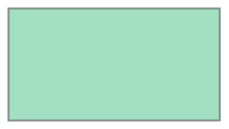

In [3]:
# Merge the GBIF observations into a single geometry
gbif_union = gbif_gdf.geometry.union_all().envelope
gbif_union

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Run the code below, which converts your Polygon to a special type of
GeoJSON needed for compatibility with the ArcGIS Feature Service. Check
out and explore this data structure. How would you extract the
geographic coordinates?</p></div></div>

In [4]:
# Convert geometry to geoJSON
gbif_geojson = gbif_union.__geo_interface__

gbif_geojson

{'type': 'Polygon',
 'coordinates': (((-128.604153, -56.459571),
   (83.61557, -56.459571),
   (83.61557, 56.116539),
   (-128.604153, 56.116539),
   (-128.604153, -56.459571)),)}

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What type of Python object is this geoJSON? How will you get the
geographic coordinates only?</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace <code>feature-key</code> with the coordinate key you noted
above.</li>
<li>Replace CRS with the CRS of your GBIF download. It should be
formatted as a 4-digit number, e.g. if the CRS is EPSG:1234, you should
put <code>1234</code> into Python.</li>
</ol></div></div>

This geoJSON is the dictionary type of python object. It stores the polygon
data from the gbif_union observations. You can extract just the coordinates
by calling for them with gbif_geojson["coordinates"].

In [5]:
# Construct ArcGIS-compatible JSON
arcgis_geom = json.dumps(dict(
    rings=gbif_geojson["coordinates"],
    spatialReference={"wkid": 4326}
))


### STEP 2: Download data from the ArcGIS FeatureService

In [6]:
# Prepare API request
eco_url = (
    "https://services5.arcgis.com/0AFsQflykfA9lXZn"
    "/ArcGIS/rest/services"
    "/WWF_Terrestrial_Ecoregions_Of_The_World_official_teow"
    "/FeatureServer/0/query")
eco_params = {
    "f": "geojson",
    "where": "1=1",
    "outFields": "eco_code,area_km2",
    "returnGeometry": "true",
    # Return polygons containing any GBIF observation
    "spatialRel": "esriSpatialRelIntersects",  
    "geometryType": "esriGeometryPolygon",
    # Override web Mercator server default
    "inSR": "4326",
    "outSR": "4326",
    # Must format geometry
    "geometry": arcgis_geom
}

# Submit API request
eco_resp = requests.get(
    eco_url, params=eco_params,
    headers={"Accept-Encoding": "identity"})
eco_resp.raise_for_status()

# Load binary data to DataFrame
eco_gdf = gpd.read_file(BytesIO(eco_resp.content))

# Check the download
eco_gdf.head()

,eco_code,area_km2,geometry
0,NT0404,248398,"POLYGON ((-74.32428 -45.42114, -74.33501 -45.4..."
1,NT0404,248398,"POLYGON ((-74.1213 -44.09145, -74.12397 -44.08..."
2,AT1012,19515,"POLYGON ((30.7211 -29.71616, 30.71552 -29.7090..."
3,NT0702,125589,"POLYGON ((-67.98364 -13.79293, -67.98972 -13.7..."
4,NT0128,114506,"POLYGON ((-72.72287 -3.54497, -72.724 -3.5443,..."


<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Now, make a quick plot of your download to make sure that it worked
correctly.</p></div></div>

<Axes: >

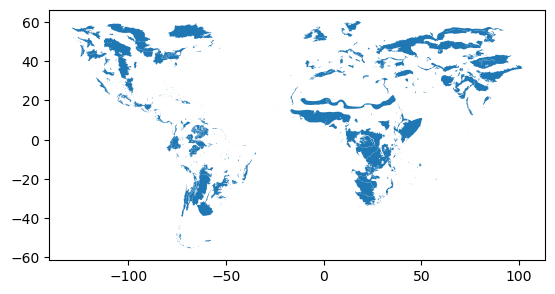

In [7]:
# Plot the ecoregion data
eco_gdf.plot()

### STEP 3 (Optional): Save your data

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Create a new directory in your data directory for the ecoregions
data.</li>
<li>Define a path to a Shapefile where you will save the ecoregions
data.</li>
<li>Save the ecoregions to the file.</li>
</ol></div></div>

In [11]:
# Save the ecoregion data
eco_dir = project.project_dir / 'ecoregions'
eco_dir.mkdir(exist_ok=True)
eco_path = eco_dir / 'ecoregions.shp'
eco_gdf.to_file(eco_path)